In [ ]:
!pip3 install tensorflow_text

In [ ]:
!pip install transformers

In [ ]:
!wget https://raw.githubusercontent.com/krishnaaxo/Rev.Conf/main/2018_iclr.csv
!wget https://raw.githubusercontent.com/krishnaaxo/Rev.Conf/main/2019_iclr.csv
!wget https://raw.githubusercontent.com/krishnaaxo/Rev.Conf/main/2021_iclr.csv

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D,Flatten,SpatialDropout1D,Bidirectional,LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import torch
import transformers as ppb
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('2019_iclr.csv')
df['confidence'] = df['confidence'].astype(str).str[0]
df['review'] = df['review']
review = df[['confidence','review']]
review = review.dropna(axis=0)
review['confidence'] = review['confidence'].astype(int) -1
df=review
df.head()

In [6]:
review['confidence'] = review['confidence'].astype(int) -1
df=review
df.head()

In [7]:
df=review
df.head()

,confidence,review
0,4,The paper proposes an approach to learn nonlin...
1,3,"This paper aims to estimate time-delayed, nonl..."
2,3,"In the manuscript entitled ""Neural Causal Disc..."
4,4,Major Contribution:\nThis paper details a meth...
5,3,# Summary\n\nThis submission proposes a multi-...


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'],df['confidence'], stratify=df['confidence'])

In [10]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [11]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132725 , -0.88845736, ..., -0.7474887 ,
        -0.75314736,  0.91964495],
       [-0.8720836 , -0.50543964, -0.94446665, ..., -0.858475  ,
        -0.7174535 ,  0.88082975]], dtype=float32)>

In [26]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
hidden1  = tf.keras.layers.Dense(32, activation='relu', name="hidden1")(l)
hidden2  = tf.keras.layers.Dense(16, activation='relu', name="hidden2")(hidden1)
hidden3  = tf.keras.layers.Dense(8, activation='relu', name="hidden3")(hidden2)
output = tf.keras.layers.Dense(1, activation='relu', name="output")(hidden3)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [output])

optimzer=Adam(learning_rate=1e-5)
    
model.compile(loss='mean_squared_error',optimizer=optimzer)     

In [27]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [30]:
model.fit(X_train, y_train, epochs=10,batch_size=16)

Epoch 1/10
224/224 [==============================] - 28s 127ms/step - loss: 0.7317
Epoch 2/10
224/224 [==============================] - 28s 127ms/step - loss: 0.7349
Epoch 3/10
224/224 [==============================] - 28s 126ms/step - loss: 0.7474
Epoch 4/10
224/224 [==============================] - 28s 127ms/step - loss: 0.7298
Epoch 5/10
224/224 [==============================] - 28s 126ms/step - loss: 0.7359
Epoch 6/10
224/224 [==============================] - 28s 126ms/step - loss: 0.7303
Epoch 7/10
224/224 [==============================] - 28s 127ms/step - loss: 0.7265
Epoch 8/10
224/224 [==============================] - 28s 126ms/step - loss: 0.7257
Epoch 9/10
224/224 [==============================] - 28s 126ms/step - loss: 0.7283
Epoch 10/10
224/224 [==============================] - 28s 126ms/step - loss: 0.7287


In [15]:
model.evaluate(X_test, y_test)

38/38 [==============================] - 10s 250ms/step - loss: 0.6960


0.6960082650184631

In [31]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
from matplotlib import pyplot
import seaborn as sns
def metrics(expected , predicted):
  # Mean absolute error
  print("The rmse is " + str(np.sqrt(mean_squared_error(expected, predicted))))
  print("The mae is " + str(mean_absolute_error(expected, predicted)))
  print("The r2 is " + str(r2_score(expected, predicted)))
  print("Standard Deviation of predicted" + str(np.std(predicted)))
  plt.figure()
  ax1 = sns.distplot(predicted)
  ax2 = sns.distplot(expected)
  plt.axvline(np.mean(predicted) , color='b' , linestyle='dashed' , linewidth='2')
  plt.axvline(np.mean(expected) , color='orange' , linestyle='dashed' , linewidth='2')
  # pyplot.plot(err)
  # pyplot.xticks(ticks=[i for i in range(len(err))], labels=predicted)
  # pyplot.xlabel('Predicted Value')
  # pyplot.ylabel('Mean Squared Error')
  # pyplot.show()
  # mean sq error
  # r2


The rmse is 0.8358717135764724
The mae is 0.6700052399278988
The r2 is -0.01135010100584899
Standard Deviation of predicted0.13401112
And for training values -------------------
The rmse is 0.8368661418202529
The mae is 0.6706235493193679
The r2 is -0.015256024926805445
Standard Deviation of predicted0.13621247


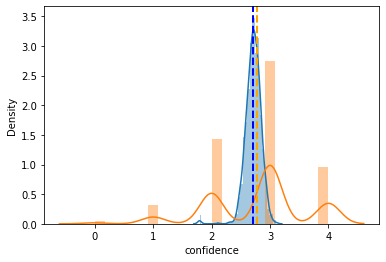

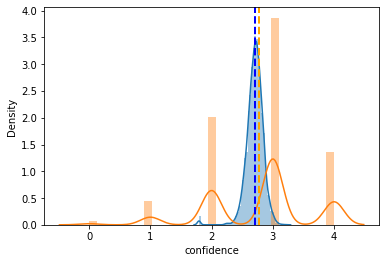

In [32]:
predicted = model.predict(X_test)
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = model.predict(X_train)
metrics(y_train , predicted2)

# ***2018***

In [33]:
df = pd.read_csv('2018_iclr.csv')
df['confidence'] = df['confidence'].astype(str).str[0]
df['review'] = df['review']
review = df[['confidence','review']]
review = review.dropna(axis=0)
review['confidence'] = review['confidence'].astype(int) -1
df=review
df.head()

,confidence,review
0,3,The idea of using cross-task transfer performa...
1,3,This paper proposes a method for multitask and...
2,3,The authors propose techniques for multitask a...
3,2,\nSummary: \n- This paper proposes a hand-desi...
4,2,Summary\n - This paper mainly focuses on a cou...


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'],df['confidence'], stratify=df['confidence'])

In [35]:
model.fit(X_train, y_train, epochs=10,batch_size=16)

Epoch 1/10
140/140 [==============================] - 18s 126ms/step - loss: 0.7369
Epoch 2/10
140/140 [==============================] - 18s 125ms/step - loss: 0.7164
Epoch 3/10
140/140 [==============================] - 18s 125ms/step - loss: 0.7220
Epoch 4/10
140/140 [==============================] - 18s 126ms/step - loss: 0.7234
Epoch 5/10
140/140 [==============================] - 18s 127ms/step - loss: 0.7230
Epoch 6/10
140/140 [==============================] - 17s 125ms/step - loss: 0.7183
Epoch 7/10
140/140 [==============================] - 17s 125ms/step - loss: 0.7084
Epoch 8/10
140/140 [==============================] - 18s 125ms/step - loss: 0.7269
Epoch 9/10
140/140 [==============================] - 17s 125ms/step - loss: 0.7245
Epoch 10/10
140/140 [==============================] - 17s 125ms/step - loss: 0.7211


In [36]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 7s 244ms/step - loss: 0.6864


0.6864112019538879

The rmse is 0.8284993654857358
The mae is 0.6188112298112032
The r2 is 0.008541368391283277
Standard Deviation of predicted0.13469559
And for training values -------------------
The rmse is 0.831860905462727
The mae is 0.6223555402005656
The r2 is -0.006384044847056236
Standard Deviation of predicted0.12923469


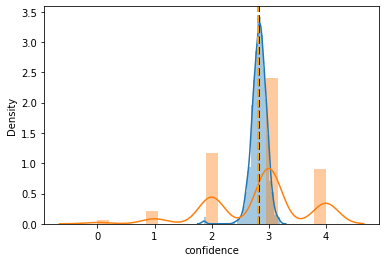

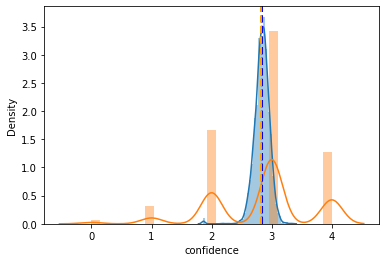

In [37]:
predicted = model.predict(X_test)
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = model.predict(X_train)
metrics(y_train , predicted2)

# ***2021***

In [38]:
df = pd.read_csv('2021_iclr.csv')
df['confidence'] = df['confidence'].astype(str).str[0]
df['review'] = df['review']
review = df[['confidence','review']]
review = review.dropna(axis=0)
review['confidence'] = review['confidence'].astype(int) -1
df=review
df.head()

,confidence,review
0,3,Review:\n\nThis paper carries out a large-scal...
1,2,Review:\n\n###################################...
2,2,Review:\n\nThe authors survey a wide variety o...
3,3,Review:\n\nThe paper presents an empirical eva...
4,3,"Review:\n\nIn general, it is not clear, at lea..."


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'],df['confidence'], stratify=df['confidence'])

In [40]:
model.fit(X_train, y_train, epochs=10,batch_size=16)

Epoch 1/10
155/155 [==============================] - 20s 129ms/step - loss: 0.6839
Epoch 2/10
155/155 [==============================] - 20s 128ms/step - loss: 0.6803
Epoch 3/10
155/155 [==============================] - 20s 128ms/step - loss: 0.6763
Epoch 4/10
155/155 [==============================] - 20s 128ms/step - loss: 0.6797
Epoch 5/10
155/155 [==============================] - 20s 128ms/step - loss: 0.6815
Epoch 6/10
155/155 [==============================] - 20s 128ms/step - loss: 0.6744
Epoch 7/10
155/155 [==============================] - 20s 127ms/step - loss: 0.6724
Epoch 8/10
155/155 [==============================] - 20s 128ms/step - loss: 0.6715
Epoch 9/10
155/155 [==============================] - 20s 128ms/step - loss: 0.6659
Epoch 10/10
155/155 [==============================] - 20s 127ms/step - loss: 0.6713


In [41]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 7s 258ms/step - loss: 0.6499


0.6499214768409729

The rmse is 0.8061770342854722
The mae is 0.6657752139020806
The r2 is -0.017973950315651077
Standard Deviation of predicted0.10020184
And for training values -------------------
The rmse is 0.8063033570873408
The mae is 0.6664961652326642
The r2 is -0.009715402340308987
Standard Deviation of predicted0.10563832


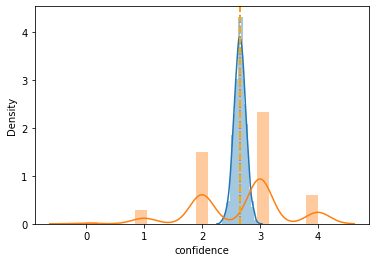

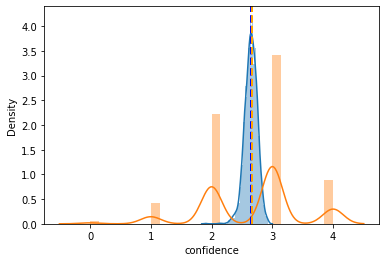

In [42]:
predicted = model.predict(X_test)
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = model.predict(X_train)
metrics(y_train , predicted2)